## 1.临床

In [2]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import contextlib
import json
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 定义一个辅助函数，用于格式化 p 值
def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

# 打开 Excel 文件并读取数据
df = pd.read_excel('rawdata.xlsx')

# 计算所需的差值变量
df['LDH_diff'] = df['LDH_followup'] - df['LDH_baseline']
df['Negative_diff'] = df['Negative symptom at follow-up'] 

from sklearn.preprocessing import StandardScaler

# 只标准化我们需要的变量
scaler = StandardScaler()
df[['LDH_diff', 'Negative_diff']] = scaler.fit_transform(df[['LDH_diff', 'Negative_diff']])

# 定义 bootstrap 函数，专门为 LDH_diff 中介变量
def bootstrap_indirect_effect(data, mediator="LDH_diff", n_boot=10000, seed=42):
    np.random.seed(seed)
    boot_effects = []
    n = len(data)
    for i in range(n_boot):
        sample = data.sample(n, replace=True)
        # 拟合模型
        mod_m = smf.ols(f'{mediator} ~ C(Subtype)', data=sample).fit()
        mod_y = smf.ols(f'Negative_diff ~ C(Subtype) + {mediator}', data=sample).fit()
        a = mod_m.params['C(Subtype)[T.2]']
        b = mod_y.params[f'{mediator}']
        boot_effects.append(a * b)
    lower = np.percentile(boot_effects, 2.5)
    upper = np.percentile(boot_effects, 97.5)
    boot_effects = np.array(boot_effects)
    # 双尾检验 p 值计算
    p_value_indirect = 2 * min(np.mean(boot_effects < 0), np.mean(boot_effects > 0))
    p_value_indirect = min(p_value_indirect, 1.0)
    return lower, upper, p_value_indirect

# 创建结果目录
if not os.path.exists("results"):
    os.makedirs("results")

# 创建绘图目录
if not os.path.exists("plots"):
    os.makedirs("plots")

# 创建图像目录
if not os.path.exists("image"):
    os.makedirs("image")

# 将所有 print 输出整合保存到 txt 文件中
with open('results/print_outputNegative_diff_LDH_only.txt', 'w', encoding='utf-8') as f:
    with contextlib.redirect_stdout(f):
        # 查看数据的列名，确保与代码中变量名一致
        print("数据列名：", df.columns.tolist())

        # 计算总效应模型（不含中介变量）
        total_effect_model = smf.ols('Negative_diff ~ C(Subtype)', data=df).fit()
        print("\n总效应模型 (Negative_diff ~ X ):")
        print(total_effect_model.summary())
        
        total_effect_coef = total_effect_model.params['C(Subtype)[T.2]']
        total_effect_p = total_effect_model.pvalues['C(Subtype)[T.2]']
        print(f"\n总效应 (Total Effect) = {total_effect_coef:.4f}, p = {fmt_p(total_effect_p)}")
        
        # 仅分析 LDH_diff 中介变量
        mediator = "LDH_diff"
        print("\n---------------------")
        print(f"中介变量： {mediator}")
        print("---------------------\n")
        
        # 中介模型：检验 Subtype 对 mediator 的影响
        model_m = smf.ols(f'{mediator} ~ C(Subtype)', data=df).fit()
        print(f"中介模型 (M ~ X) 结果 for {mediator}:")
        print(model_m.summary())
        
        # 因变量模型：检验 Subtype 和 mediator 对 Negative_diff 的影响
        model_y = smf.ols(f'Negative_diff ~ C(Subtype) + {mediator}', data=df).fit()
        print(f"\n因变量模型 (Negative_diff ~ X + M) 结果 for {mediator}:")
        print(model_y.summary())
        
        # 提取回归系数
        a_coef = model_m.params['C(Subtype)[T.2]']   # Subtype 对 mediator 的效应（路径 a）
        p_value_a = model_m.pvalues['C(Subtype)[T.2]']
        
        b_coef = model_y.params[f'{mediator}']  # mediator 对 Negative_diff 的效应（路径 b）
        p_value_b = model_y.pvalues[f'{mediator}']
        
        direct_effect = model_y.params['C(Subtype)[T.2]']  # 直接效应（路径 c'）
        p_value_c = model_y.pvalues['C(Subtype)[T.2]']
        
        # 计算间接效应 a * b
        indirect_effect = a_coef * b_coef
        
        # 计算中介效应占总效应的百分比
        proportion_mediated = (indirect_effect / total_effect_coef) * 100
        
        # 存储模型结果用于作图
        model_results = {
            'a_coef': a_coef,
            'p_value_a': p_value_a,
            'b_coef': b_coef, 
            'p_value_b': p_value_b,
            'direct_effect': direct_effect,
            'p_value_c': p_value_c,
            'indirect_effect': indirect_effect,
            'proportion': proportion_mediated
        }
        
        print(f"\n【结果：{mediator}】")
        print("间接效应 (Indirect Effect) = {:.4f}".format(indirect_effect))
        print("直接效应 (Direct Effect) = {:.4f}".format(direct_effect))
        print("总效应 (Total Effect) = {:.4f}".format(total_effect_coef))
        print("中介效应占总效应的百分比: {:.2f}%".format(proportion_mediated))
        
        # Bootstrap 计算间接效应置信区间和 p 值
        ci_lower, ci_upper, p_value_indirect = bootstrap_indirect_effect(df, mediator=mediator, n_boot=5000, seed=42)
        print("\nBootstrap 置信区间 (95%) 的间接效应: {:.4f} [{:.4f}, {:.4f}]".format(indirect_effect, ci_lower, ci_upper))
        print("间接效应的 p 值: {}".format(fmt_p(p_value_indirect)))
        
        # 保存bootstrap结果
        model_results['ci_lower'] = ci_lower
        model_results['ci_upper'] = ci_upper
        model_results['p_value_indirect'] = p_value_indirect
        
        # 保存用于作图的结果数据
        results_for_plotting = {
            'total_effect': total_effect_coef,
            'total_effect_p': total_effect_p,
            'model_results': model_results,
            'indirect_effect': indirect_effect,
            'direct_effect': direct_effect, 
            'proportion_mediated': proportion_mediated,
            'p_value_indirect': p_value_indirect
        }

        # 保存结果为JSON文件
        with open('results/model_results-negative-LDH_only.json', 'w', encoding='utf-8') as json_file:
            # 将不能直接序列化的numpy类型转换为Python类型
            def convert_numpy(obj):
                if isinstance(obj, np.integer):
                    return int(obj)
                elif isinstance(obj, np.floating):
                    return float(obj)
                elif isinstance(obj, np.ndarray):
                    return obj.tolist()
                return obj
            
            # 使用自定义转换函数序列化JSON
            json.dump(results_for_plotting, json_file, default=convert_numpy, indent=4)

print("计算完成！结果已保存到 results 目录下。")


计算完成！结果已保存到 results 目录下。


优化后的图形已保存至 './image/ldh_mediation_model.jpg'


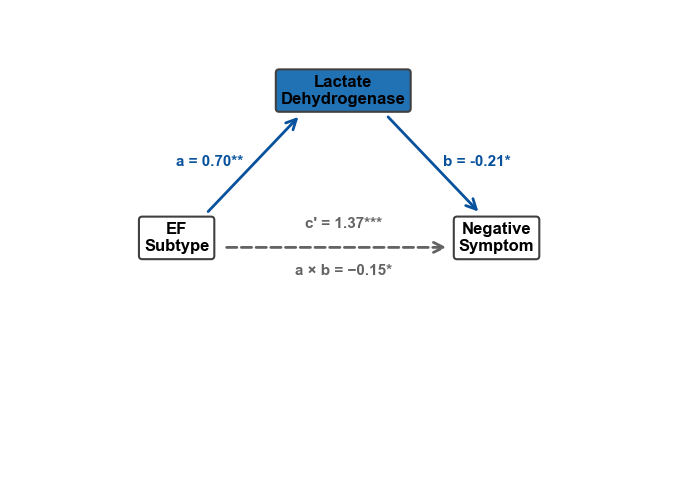

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 设置Nature规范字体
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'

# 读取分析结果
with open('results/model_results-negative-LDH_only.json', 'r', encoding='utf-8') as f:
    results = json.load(f)

# 数据提取
total_effect_coef = results['total_effect']
model_results = results['model_results']
proportion_mediated = results['proportion_mediated']
p_value_indirect = results['p_value_indirect']

# 颜色方案 (CMYK优化)
NATURE_PALETTE = {
    'main_node': '#404040',       # 深灰
    'mediator_sig': '#2171b5',    # 标准蓝
    'mediator_ns': '#bdbdbd',     # 浅灰
    'arrow_sig': '#08519c',       # 深蓝
    'arrow_ns': '#969696',        # 中灰
    'direct_effect': '#636363'    # 中灰
}

# 创建画布 (单栏尺寸优化)
plt.figure(figsize=(8.6, 7.2))  # Nature单栏常用宽度8.6cm

# 节点布局参数
NODE_PARAMS = {
    'X': {'pos': (0.25, 0.52), 'label': 'EF\nSubtype'},
    'Y': {'pos': (0.73, 0.52), 'label': 'Negative\nSymptom'},
    'LDH_diff': {'pos': (0.5, 0.83), 'label': 'Lactate\nDehydrogenase'}
}

# 优化箭头绘制函数
def draw_arrow(ax, start, end, color, linestyle='-', linewidth=2):
    ax.annotate('', xy=end, xytext=start,
                arrowprops=dict(
                    arrowstyle='->',
                    connectionstyle="arc3,rad=0",
                    linewidth=linewidth,
                    linestyle=linestyle,
                    color=color,
                    mutation_scale=18,  # 增大箭头头部
                    shrinkA=12,
                    shrinkB=12
                ))

# 绘制节点
for node, params in NODE_PARAMS.items():
    # 确定节点颜色
    if node == 'LDH_diff':
        mediator_color = NATURE_PALETTE['mediator_sig'] if p_value_indirect < 0.05 else NATURE_PALETTE['mediator_ns']
        fill_color = mediator_color
    else:
        fill_color = 'white'
    
    # 绘制节点框
    ax = plt.gca()
    ax.text(params['pos'][0], params['pos'][1], params['label'],
            ha='center', va='center', 
            fontsize=12, 
            linespacing=1.2,
            bbox=dict(
                boxstyle='round,pad=0.3,rounding_size=0.2',
                facecolor=fill_color,
                edgecolor=NATURE_PALETTE['main_node'],
                linewidth=1.5
            ))

# 绘制路径
# 路径a (X -> LDH)
a_sig = model_results['p_value_a'] < 0.05
a_color = NATURE_PALETTE['arrow_sig'] if a_sig else NATURE_PALETTE['arrow_ns']
draw_arrow(ax, (0.28, 0.55), (0.45, 0.80), a_color)
plt.text(0.3, 0.68, f"a = {model_results['a_coef']:.2f}{'*'*sum([model_results['p_value_a']<i for i in (0.05,0.01,0.001)])}",
         fontsize=11, color=a_color, ha='center', va='center')

# 路径b (LDH -> Y)
b_sig = model_results['p_value_b'] < 0.05
b_color = NATURE_PALETTE['arrow_sig'] if b_sig else NATURE_PALETTE['arrow_ns']
draw_arrow(ax, (0.55, 0.80), (0.72, 0.55), b_color)
plt.text(0.7, 0.68, f"b = {model_results['b_coef']:.2f}{'*'*sum([model_results['p_value_b']<i for i in (0.05,0.01,0.001)])}",
         fontsize=11, color=b_color, ha='center', va='center')

# 直接路径c' (X -> Y)
c_prime_sig = model_results['p_value_c'] < 0.05
draw_arrow(ax, (0.3, 0.5), (0.68, 0.5), 
           color=NATURE_PALETTE['direct_effect'],
           linestyle='--')
plt.text(0.5, 0.55, f"c' = {results['direct_effect']:.2f}{'*'*sum([model_results['p_value_c']<i for i in (0.05,0.01,0.001)])}",
         fontsize=11, color=NATURE_PALETTE['direct_effect'], ha='center', va='center')
plt.text(0.5, 0.45, f"a × b = −0.15*",
         fontsize=11, color=NATURE_PALETTE['direct_effect'], ha='center', va='center')



# 调整布局
plt.subplots_adjust(bottom=0.22)  # 为图例留出空间
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

# 保存输出
plt.savefig('./image/ldh_mediation_model.jpg', 
           dpi=1200,  # Nature推荐300-600 dpi
           bbox_inches='tight')

print("优化后的图形已保存至 './image/ldh_mediation_model.jpg'")

In [3]:
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import contextlib
import json
import os
import matplotlib.pyplot as plt

# 定义一个辅助函数，用于格式化 p 值
def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

# 打开 Excel 文件并读取数据
df = pd.read_excel('rawdata.xlsx')

# 计算所需的差值变量：仅 LDH
df['LDH_diff'] = df['LDH_followup'] - df['LDH_baseline']
df['Negative_diff'] = df['Negative symptom at follow-up'] - df['Negative symptom at baseline']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['LDH_diff', 'Negative_diff']] = scaler.fit_transform(df[['LDH_diff', 'Negative_diff']])

# 定义 bootstrap 函数，只针对单一中介变量
def bootstrap_indirect_effect(data, mediator, n_boot=5000, seed=42):
    np.random.seed(seed)
    boot_effects = []
    n = len(data)
    for _ in range(n_boot):
        sample = data.sample(n, replace=True)
        mod_m = smf.ols(f'{mediator} ~ C(Subtype)', data=sample).fit()
        mod_y = smf.ols(f'Negative_diff ~ C(Subtype) + {mediator}', data=sample).fit()
        a = mod_m.params['C(Subtype)[T.2]']
        b = mod_y.params[mediator]
        boot_effects.append(a * b)
    boot_effects = np.array(boot_effects)
    lower = np.percentile(boot_effects, 2.5)
    upper = np.percentile(boot_effects, 97.5)
    p_val = 2 * min(np.mean(boot_effects < 0), np.mean(boot_effects > 0))
    return lower, upper, min(p_val, 1.0)

# 创建结果目录
if not os.path.exists("results"):
    os.makedirs("results")

with open('results/print_output_LDH_diff.txt', 'w', encoding='utf-8') as f:
    with contextlib.redirect_stdout(f):
        print("数据列名：", df.columns.tolist())

        # 总效应模型
        total_mod = smf.ols('Negative_diff ~ C(Subtype)', data=df).fit()
        print("\n总效应模型 (Negative_diff ~ Subtype):")
        print(total_mod.summary())
        total_coef = total_mod.params['C(Subtype)[T.2]']
        total_p = total_mod.pvalues['C(Subtype)[T.2]']
        print(f"\nTotal Effect = {total_coef:.4f}, p = {fmt_p(total_p)}")

        # 仅检验 LDH_diff 路径
        mediator = 'LDH_diff'
        print("\n---------------------")
        print(f"中介变量： {mediator}")
        print("---------------------\n")

        # 路径 a：Subtype → LDH_diff
        mod_m = smf.ols(f'{mediator} ~ C(Subtype)', data=df).fit()
        print("Model M ~ X:")
        print(mod_m.summary())
        a_coef = mod_m.params['C(Subtype)[T.2]']
        p_a = mod_m.pvalues['C(Subtype)[T.2]']

        # 路径 b 和 c′：Subtype & LDH_diff → Negative_diff
        mod_y = smf.ols(f'Negative_diff ~ C(Subtype) + {mediator}', data=df).fit()
        print("\nModel Y ~ X + M:")
        print(mod_y.summary())
        b_coef = mod_y.params[mediator]
        p_b = mod_y.pvalues[mediator]
        c_prime = mod_y.params['C(Subtype)[T.2]']
        p_c = mod_y.pvalues['C(Subtype)[T.2]']

        # 计算间接效应
        indirect = a_coef * b_coef
        proportion = (indirect / total_coef) * 100
        print(f"\nIndirect Effect (a * b) = {indirect:.4f}")
        print(f"Direct Effect (c′) = {c_prime:.4f}")
        print(f"Proportion mediated = {proportion:.2f}%")

        # Bootstrap 置信区间与 p 值
        ci_lower, ci_upper, p_ind = bootstrap_indirect_effect(df, mediator)
        print(f"\nBootstrap 95% CI for indirect effect: [{ci_lower:.4f}, {ci_upper:.4f}]")
        print(f"Bootstrap p-value for indirect effect: {fmt_p(p_ind)}")

        # 保存结果到 JSON
        results = {
            'total_effect': float(total_coef),
            'total_p': float(total_p),
            'mediator': mediator,
            'a_coef': float(a_coef),
            'p_a': float(p_a),
            'b_coef': float(b_coef),
            'p_b': float(p_b),
            'c_prime': float(c_prime),
            'p_c': float(p_c),
            'indirect_effect': float(indirect),
            'proportion_mediated': float(proportion),
            'ci_lower': float(ci_lower),
            'ci_upper': float(ci_upper),
            'p_indirect': float(p_ind)
        }
        with open('results/model_results_LDH.json', 'w', encoding='utf-8') as jf:
            json.dump(results, jf, indent=4)

print("计算完成！结果已保存到 results 目录下。")

计算完成！结果已保存到 results 目录下。


In [2]:
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import contextlib
import json
import os

# 定义一个辅助函数，用于格式化 p 值
def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

# 打开 Excel 文件并读取数据
df = pd.read_excel('rawdata.xlsx')

# 计算所需的差值变量
df['LYMPH_diff'] = df['LYMPH_followup'] - df['LYMPH_baseline']
df['PLR_diff'] = df['PLR_followup'] - df['PLR_baseline']
df['LDH_diff'] = df['LDH_followup'] - df['LDH_baseline']
df['Negative_diff'] = df['Negative symptom at follow-up'] 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['LYMPH_diff', 'PLR_diff', 'LDH_diff', 'Negative_diff']] = scaler.fit_transform(df[['LYMPH_diff', 'PLR_diff', 'LDH_diff', 'Negative_diff']])

# 定义 bootstrap 函数，参数 mediator 表示中介变量名称（LYMPH_diff, PLR_diff, LDH_diff）
def bootstrap_indirect_effect(data, mediator, n_boot=3000, seed=42):
    np.random.seed(seed)
    boot_effects = []
    n = len(data)
    for i in range(n_boot):
        sample = data.sample(n, replace=True)
        # 重新拟合模型，均控制 Age、Gender 和 Education_years
        mod_m = smf.ols(f'{mediator} ~ C(Subtype)', data=sample).fit()
        mod_y = smf.ols(f'Negative_diff ~ C(Subtype) + {mediator}', data=sample).fit()
        a = mod_m.params['C(Subtype)[T.2]']
        b = mod_y.params[f'{mediator}']
        boot_effects.append(a * b)
    lower = np.percentile(boot_effects, 2.5)
    upper = np.percentile(boot_effects, 97.5)
    boot_effects = np.array(boot_effects)
    # 双尾检验 p 值计算
    p_value_indirect = 2 * min(np.mean(boot_effects < 0), np.mean(boot_effects > 0))
    p_value_indirect = min(p_value_indirect, 1.0)
    return lower, upper, p_value_indirect

# 修改：增加同时考虑多个中介变量的函数
def bootstrap_parallel_indirect_effects(data, mediators, n_boot=5000, seed=42):
    np.random.seed(seed)
    n = len(data)
    boot_effects_dict = {m: [] for m in mediators}
    boot_total_indirect = []
    
    for i in range(n_boot):
        sample = data.sample(n, replace=True)
        total_indirect = 0
        
        for mediator in mediators:
            mod_m = smf.ols(f'{mediator} ~ C(Subtype)', data=sample).fit()
            mod_y = smf.ols(f'Negative_diff ~ C(Subtype) + {mediator}', data=sample).fit()
            a = mod_m.params['C(Subtype)[T.2]']
            b = mod_y.params[f'{mediator}']
            indirect = a * b
            boot_effects_dict[mediator].append(indirect)
            total_indirect += indirect
        
        boot_total_indirect.append(total_indirect)
    
    results = {}
    for mediator in mediators:
        effects = np.array(boot_effects_dict[mediator])
        lower = np.percentile(effects, 2.5)
        upper = np.percentile(effects, 97.5)
        p_value = 2 * min(np.mean(effects < 0), np.mean(effects > 0))
        p_value = min(p_value, 1.0)
        results[mediator] = {'lower': lower, 'upper': upper, 'p_value': p_value}
    
    # 总间接效应
    total_effects = np.array(boot_total_indirect)
    total_lower = np.percentile(total_effects, 2.5)
    total_upper = np.percentile(total_effects, 97.5)
    total_p_value = 2 * min(np.mean(total_effects < 0), np.mean(total_effects > 0))
    total_p_value = min(total_p_value, 1.0)
    results['total'] = {'lower': total_lower, 'upper': total_upper, 'p_value': total_p_value}
    
    # 计算中介变量之间的效应大小差异
    for i, m1 in enumerate(mediators):
        for j, m2 in enumerate(mediators):
            if i < j:  # 避免重复比较
                diff = np.array(boot_effects_dict[m1]) - np.array(boot_effects_dict[m2])
                diff_p_value = 2 * min(np.mean(diff < 0), np.mean(diff > 0))
                diff_p_value = min(diff_p_value, 1.0)
                results[f'{m1}_vs_{m2}'] = {
                    'diff_p_value': diff_p_value,
                    'mean_diff': np.mean(diff)
                }
    
    return results

# 创建结果目录
if not os.path.exists("results"):
    os.makedirs("results")

# 将所有 print 输出整合保存到 txt 文件中
with open('results/print_outputNegative_diff.txt', 'w', encoding='utf-8') as f:
    with contextlib.redirect_stdout(f):
        # 查看数据的列名，确保与代码中变量名一致
        print("数据列名：", df.columns.tolist())

        # 计算总效应模型（不含中介变量）
        total_effect_model = smf.ols('Negative_diff ~ C(Subtype)', data=df).fit()
        print("\n总效应模型 (Negative_diff ~ X ):")
        print(total_effect_model.summary())
        
        total_effect_coef = total_effect_model.params['C(Subtype)[T.2]']
        total_effect_p = total_effect_model.pvalues['C(Subtype)[T.2]']
        print(f"\n总效应 (Total Effect) = {total_effect_coef:.4f}, p = {fmt_p(total_effect_p)}")
        
        # 循环分析中介变量，分别为 LYMPH_diff, PLR_diff, LDH_diff
        mediators = ["LYMPH_diff", "PLR_diff", "LDH_diff"]
        indirect_effects = {}
        direct_effects = {}
        proportion_mediated = {}
        all_model_results = {}
        
        for mediator in mediators:
            print("\n---------------------")
            print(f"中介变量： {mediator}")
            print("---------------------\n")
            
            # 中介模型：检验 Subtype 对 mediator 的影响（控制 Age、Gender 和 Education_years）
            model_m = smf.ols(f'{mediator} ~ C(Subtype)', data=df).fit()
            print(f"中介模型 (M ~ X) 结果 for {mediator}:")
            print(model_m.summary())
            
            # 因变量模型：检验 Subtype 和 mediator 对 Negative_diff 的影响（控制 Age、Gender 和 Education_years）
            model_y = smf.ols(f'Negative_diff ~ C(Subtype) + {mediator}', data=df).fit()
            print(f"\n因变量模型 (Negative_diff ~ X + M) 结果 for {mediator}:")
            print(model_y.summary())
            
            # 提取回归系数
            a_coef = model_m.params['C(Subtype)[T.2]']   # Subtype 对 mediator 的效应（路径 a）
            p_value_a = model_m.pvalues['C(Subtype)[T.2]']
            
            b_coef = model_y.params[f'{mediator}']  # mediator 对 Negative_diff 的效应（路径 b）
            p_value_b = model_y.pvalues[f'{mediator}']
            
            direct_effect = model_y.params['C(Subtype)[T.2]']  # 直接效应（路径 c'）
            p_value_c = model_y.pvalues['C(Subtype)[T.2]']
            
            # 计算间接效应 a * b
            indirect_effect = a_coef * b_coef
            
            # 存储结果用于后续比较
            indirect_effects[mediator] = indirect_effect
            direct_effects[mediator] = direct_effect
            proportion_mediated[mediator] = (indirect_effect / total_effect_coef) * 100
            
            # 存储模型结果用于作图
            all_model_results[mediator] = {
                'a_coef': a_coef,
                'p_value_a': p_value_a,
                'b_coef': b_coef, 
                'p_value_b': p_value_b,
                'direct_effect': direct_effect,
                'p_value_c': p_value_c,
                'indirect_effect': indirect_effect,
                'proportion': proportion_mediated[mediator]
            }
            
            print(f"\n【结果：{mediator}】")
            print("间接效应 (Indirect Effect) = {:.4f}".format(indirect_effect))
            print("直接效应 (Direct Effect) = {:.4f}".format(direct_effect))
            print("总效应 (Total Effect) = {:.4f}".format(total_effect_coef))
            print("中介效应占总效应的百分比: {:.2f}%".format(proportion_mediated[mediator]))
            
            # Bootstrap 计算间接效应置信区间和 p 值
            ci_lower, ci_upper, p_value_indirect = bootstrap_indirect_effect(df, mediator=mediator, n_boot=5000, seed=42)
            print("\nBootstrap 置信区间 (95%) 的间接效应: {:.4f} [{:.4f}, {:.4f}]".format(indirect_effect, ci_lower, ci_upper))
            print("间接效应的 p 值: {}".format(fmt_p(p_value_indirect)))
            
            # 保存bootstrap结果
            all_model_results[mediator]['ci_lower'] = ci_lower
            all_model_results[mediator]['ci_upper'] = ci_upper
            all_model_results[mediator]['p_value_indirect'] = p_value_indirect
        
        # 中介效应比较
        print("\n\n---------------------")
        print("中介效应比较")
        print("---------------------")
        for mediator in mediators:
            print(f"{mediator}: 间接效应 = {indirect_effects[mediator]:.4f}, 占总效应的 {proportion_mediated[mediator]:.2f}%")
        
        # 找出最强的中介效应
        strongest_mediator = max(proportion_mediated, key=proportion_mediated.get)
        print(f"\n最强的中介效应是 {strongest_mediator}，占总效应的 {proportion_mediated[strongest_mediator]:.2f}%")
        
        # 多重中介效应分析（并行中介分析）
        print("\n\n---------------------")
        print("多重中介效应分析（并行）")
        print("---------------------")
        
        # 构建包含所有中介变量的模型
        formula_all_mediators = 'Negative_diff ~ C(Subtype) + ' + ' + '.join(mediators)
        model_all = smf.ols(formula_all_mediators, data=df).fit()
        print("\n包含所有中介变量的模型:")
        print(model_all.summary())
        
        # 使用Bootstrap计算并行中介效应
        parallel_results = bootstrap_parallel_indirect_effects(df, mediators)
        
        print("\n并行中介效应结果:")
        for mediator in mediators:
            result = parallel_results[mediator]
            print(f"\n{mediator}:")
            print(f"Bootstrap 置信区间 (95%): [{result['lower']:.4f}, {result['upper']:.4f}]")
            print(f"p 值: {fmt_p(result['p_value'])}")
        
        print("\n总间接效应:")
        total_result = parallel_results['total']
        print(f"Bootstrap 置信区间 (95%): [{total_result['lower']:.4f}, {total_result['upper']:.4f}]")
        print(f"p 值: {fmt_p(total_result['p_value'])}")
        
        # 中介效应的差异检验
        print("\n中介效应差异检验:")
        for key, result in parallel_results.items():
            if '_vs_' in key:
                m1, m2 = key.split('_vs_')
                print(f"{m1} vs {m2}:")
                print(f"平均差异: {result['mean_diff']:.4f}")
                print(f"差异的 p 值: {fmt_p(result['diff_p_value'])}")

        # 保存用于作图的结果数据
        results_for_plotting = {
            'total_effect': total_effect_coef,
            'total_effect_p': total_effect_p,
            'strongest_mediator': strongest_mediator,
            'model_results': all_model_results,
            'indirect_effects': indirect_effects,
            'direct_effects': direct_effects, 
            'proportion_mediated': proportion_mediated,
            'parallel_results': parallel_results
        }

        # 保存结果为JSON文件
        with open('results/model_results-negative.json', 'w', encoding='utf-8') as json_file:
            # 将不能直接序列化的numpy类型转换为Python类型
            def convert_numpy(obj):
                if isinstance(obj, np.integer):
                    return int(obj)
                elif isinstance(obj, np.floating):
                    return float(obj)
                elif isinstance(obj, np.ndarray):
                    return obj.tolist()
                return obj
            
            # 使用自定义转换函数序列化JSON
            json.dump(results_for_plotting, json_file, default=convert_numpy, indent=4)

print("计算完成！结果已保存到 results 目录下。")
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import numpy as np

# Function for formatting p-values
def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

# Create directory for saving plots
if not os.path.exists("plots"):
    os.makedirs("plots")

# Read analysis results
with open('results/model_results-negative.json', 'r', encoding='utf-8') as f:
    results = json.load(f)

# Extract required data
total_effect_coef    = results['total_effect']
total_effect_p       = results['total_effect_p']
strongest_mediator   = results['strongest_mediator']
model_results        = results['model_results']
indirect_effects     = results['indirect_effects']
direct_effects       = results['direct_effects']
proportion_mediated  = results['proportion_mediated']
parallel_results     = results['parallel_results']

# List of mediators
mediators = list(model_results.keys())

# Define color scheme
mediator_colors = {
    'LYMPH_diff': '#1f77b4',
    'PLR_diff':   '#ff7f0e',
    'LDH_diff':   '#2ca02c'
}

mediator_labels = {
    'LYMPH_diff': 'Lymphocytes\n(%)',
    'PLR_diff':   'Platelet-\nLymphocyte Ratio',
    'LDH_diff':   'Lactate\nDehydrogenase (U/L)'
}

node_facecolor   = "#f0f0f0"
node_edgecolor   = "#333333"
arrow_color      = "#1f77b4"
direct_arrow_color = "#ff7f0e"

# 3. Draw combined mediation model visualization
plt.figure(figsize=(10, 9))

# 定义节点位置
positions = {
    'X':           (0.15, 0.5),
    'Y':           (0.85, 0.5),
    'LYMPH_diff':  (0.5,  0.7),
    'PLR_diff':    (0.5,  0.5),
    'LDH_diff':    (0.5,  0.3)
}

# Node dimensions parameters
node_width       = 0.12
node_height      = 0.07
main_node_pad    = 0.1
mediator_node_pad = 0.3

# Arrow parameters
arrow_shrink_a  = 15
arrow_shrink_b  = 15
arrow_width     = 2
arrow_head_size = 15

mediator_offset = 0.05

# Text position adjustment parameters
a_text_offset_x = {
    'LYMPH_diff': -0.01,
    'PLR_diff':    0.03,
    'LDH_diff':   -0.05
}
a_text_offset_y = {
    'LYMPH_diff':  0.04,
    'PLR_diff':   -0.05,
    'LDH_diff':   -0.01
}
b_text_offset_x = {
    'LYMPH_diff':  0.03,
    'PLR_diff':   -0.04,
    'LDH_diff':    0.05
}
b_text_offset_y = {
    'LYMPH_diff':  0.04,
    'PLR_diff':   -0.05,
    'LDH_diff':   -0.03
}

# 将 c' 文本再往下移一些
c_text_offset_y = -0.08

# Function to get the coordinates of node edges
def get_edge_point(from_node, to_node):
    dx = positions[to_node][0] - positions[from_node][0]
    dy = positions[to_node][1] - positions[from_node][1]
    length = np.hypot(dx, dy)
    dx /= length
    dy /= length

    # Start point
    if from_node in ['X', 'Y']:
        if abs(dx) > abs(dy):
            start_x = positions[from_node][0] + (node_width - 0.04) * np.sign(dx)
            start_y = positions[from_node][1]
        else:
            start_x = positions[from_node][0]
            start_y = positions[from_node][1] + node_height * np.sign(dy)
    else:
        start_x = positions[from_node][0] + mediator_offset * np.sign(dx)
        start_y = positions[from_node][1] + (mediator_offset/2) * np.sign(dy)

    # End point
    if to_node in ['X', 'Y']:
        if abs(dx) > abs(dy):
            end_x = positions[to_node][0] - (node_width - 0.04) * np.sign(dx)
            end_y = positions[to_node][1]
        else:
            end_x = positions[to_node][0]
            end_y = positions[to_node][1] - node_height * np.sign(dy)
    else:
        end_x = positions[to_node][0] - mediator_offset * np.sign(dx)
        end_y = positions[to_node][1] - (mediator_offset/2) * np.sign(dy)

    return (start_x, start_y), (end_x, end_y)

# Draw nodes
for node, pos in positions.items():
    if node == 'X':
        label, bbox_pad = 'EF\nSubtype', main_node_pad
        color = node_facecolor
    elif node == 'Y':
        label, bbox_pad = 'Negative\nSymptom', main_node_pad
        color = node_facecolor
    else:
        label, bbox_pad = mediator_labels[node], mediator_node_pad
        if parallel_results[node]['p_value'] < 0.05:
            color = mediator_colors[node]
        else:
            color = '#d3d3d3'
    plt.text(pos[0], pos[1], label,
             ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle=f'round,pad={bbox_pad}', fc=color, ec=node_edgecolor))

# X to mediator arrows (path a)
for m in mediators:
    is_sig_a = model_results[m]['p_value_a'] < 0.05
    path_color = mediator_colors[m] if is_sig_a else 'gray'
    start_pt, end_pt = get_edge_point('X', m)
    plt.annotate('', xy=end_pt, xytext=start_pt,
                 arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0",
                                 linewidth=arrow_width, mutation_scale=arrow_head_size,
                                 shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b,
                                 color=path_color))
    midx = (start_pt[0] + end_pt[0]) / 2
    midy = (start_pt[1] + end_pt[1]) / 2
    plt.text(midx + a_text_offset_x[m], midy + a_text_offset_y[m],
             f"a = {model_results[m]['a_coef']:.2f}" + ("*" if is_sig_a else ""),
             ha='center', va='center', fontsize=10, color=path_color, weight='bold')

# Mediator to Y arrows (path b)
for m in mediators:
    is_sig_b = model_results[m]['p_value_b'] < 0.05
    path_color = mediator_colors[m] if is_sig_b else 'gray'
    start_pt, end_pt = get_edge_point(m, 'Y')
    plt.annotate('', xy=end_pt, xytext=start_pt,
                 arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0",
                                 linewidth=arrow_width, mutation_scale=arrow_head_size,
                                 shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b,
                                 color=path_color))
    midx = (start_pt[0] + end_pt[0]) / 2
    midy = (start_pt[1] + end_pt[1]) / 2
    plt.text(midx + b_text_offset_x[m], midy + b_text_offset_y[m],
             f"b = {model_results[m]['b_coef']:.2f}" + ("*" if is_sig_b else ""),
             ha='center', va='center', fontsize=10, color=path_color, weight='bold')

# X to Y direct path (c')
start_pt, end_pt = get_edge_point('X', 'Y')
plt.annotate('', xy=end_pt, xytext=start_pt,
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0",
                             linewidth=arrow_width, linestyle='--',
                             mutation_scale=arrow_head_size,
                             shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b,
                             color='black'))
direct_midx = (start_pt[0] + end_pt[0]) / 2
direct_midy = (start_pt[1] + end_pt[1]) / 2 + c_text_offset_y


# Legend
legend_elements = []
for m in mediators:
    clean_label = mediator_labels[m].replace('\n', ' ')
    if parallel_results[m]['p_value'] < 0.05:
        legend_elements.append(
            Patch(facecolor=mediator_colors[m],
                  label=f"{clean_label}: {proportion_mediated[m]:.1f}% (p={fmt_p(parallel_results[m]['p_value'])})")
        )
    else:
        legend_elements.append(
            Patch(facecolor='#d3d3d3',
                  label=f"{clean_label}: {proportion_mediated[m]:.1f}% (p={fmt_p(parallel_results[m]['p_value'])})")
        )
legend_elements.append(
    Patch(facecolor='none', edgecolor='black', linestyle='--',
          label=f"Direct Effect: {direct_effects[strongest_mediator]:.2f}")
)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

# Save and show
plt.savefig('./image/combined_mediation_model-negative.jpg', dpi=1200, bbox_inches='tight')
plt.show()

PatsyError: Error evaluating factor: NameError: name 'LYMPH_diff' is not defined
    LYMPH_diff ~ C(Subtype)
    ^^^^^^^^^^

计算完成！结果已保存到 results 目录下。


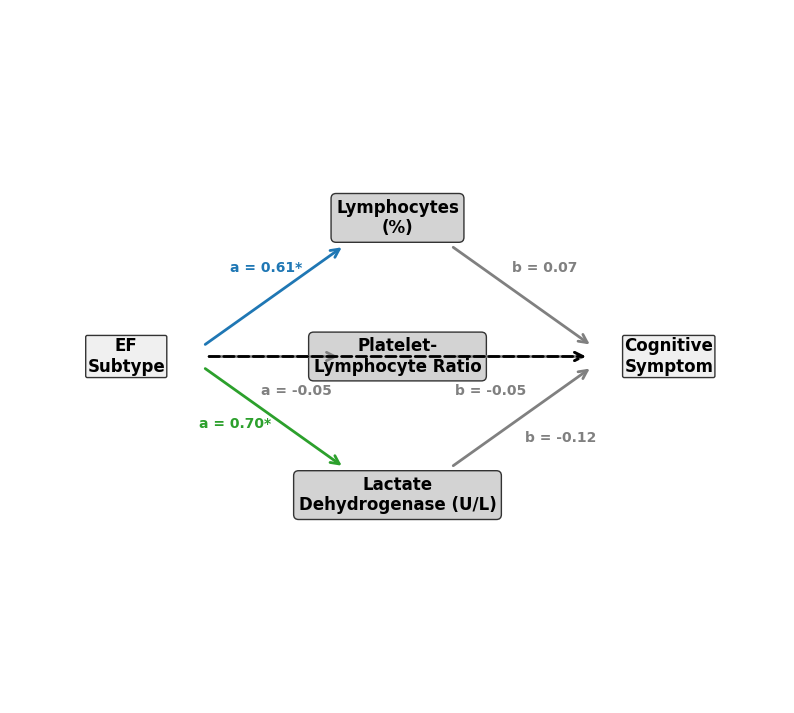

In [5]:
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import contextlib
import json
import os

# 定义一个辅助函数，用于格式化 p 值
def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

# 打开 Excel 文件并读取数据
df = pd.read_excel('rawdata.xlsx')

# 计算所需的差值变量
df['LYMPH_diff'] = df['LYMPH_followup'] - df['LYMPH_baseline']
df['PLR_diff'] = df['PLR_followup'] - df['PLR_baseline']
df['LDH_diff'] = df['LDH_followup'] - df['LDH_baseline']
df['Cognitive_diff'] = df['Cognitive impairment at follow-up'] 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['LYMPH_diff', 'PLR_diff', 'LDH_diff', 'Cognitive_diff']] = scaler.fit_transform(df[['LYMPH_diff', 'PLR_diff', 'LDH_diff', 'Cognitive_diff']])

# 定义 bootstrap 函数，参数 mediator 表示中介变量名称（LYMPH_diff, PLR_diff, LDH_diff）
def bootstrap_indirect_effect(data, mediator, n_boot=3000, seed=42):
    np.random.seed(seed)
    boot_effects = []
    n = len(data)
    for i in range(n_boot):
        sample = data.sample(n, replace=True)
        # 重新拟合模型，均控制 Age、Gender 和 Education_years
        mod_m = smf.ols(f'{mediator} ~ C(Subtype)', data=sample).fit()
        mod_y = smf.ols(f'Cognitive_diff ~ C(Subtype) + {mediator}', data=sample).fit()
        a = mod_m.params['C(Subtype)[T.2]']
        b = mod_y.params[f'{mediator}']
        boot_effects.append(a * b)
    lower = np.percentile(boot_effects, 2.5)
    upper = np.percentile(boot_effects, 97.5)
    boot_effects = np.array(boot_effects)
    # 双尾检验 p 值计算
    p_value_indirect = 2 * min(np.mean(boot_effects < 0), np.mean(boot_effects > 0))
    p_value_indirect = min(p_value_indirect, 1.0)
    return lower, upper, p_value_indirect

# 修改：增加同时考虑多个中介变量的函数
def bootstrap_parallel_indirect_effects(data, mediators, n_boot=5000, seed=42):
    np.random.seed(seed)
    n = len(data)
    boot_effects_dict = {m: [] for m in mediators}
    boot_total_indirect = []
    
    for i in range(n_boot):
        sample = data.sample(n, replace=True)
        total_indirect = 0
        
        for mediator in mediators:
            mod_m = smf.ols(f'{mediator} ~ C(Subtype)', data=sample).fit()
            mod_y = smf.ols(f'Cognitive_diff ~ C(Subtype) + {mediator}', data=sample).fit()
            a = mod_m.params['C(Subtype)[T.2]']
            b = mod_y.params[f'{mediator}']
            indirect = a * b
            boot_effects_dict[mediator].append(indirect)
            total_indirect += indirect
        
        boot_total_indirect.append(total_indirect)
    
    results = {}
    for mediator in mediators:
        effects = np.array(boot_effects_dict[mediator])
        lower = np.percentile(effects, 2.5)
        upper = np.percentile(effects, 97.5)
        p_value = 2 * min(np.mean(effects < 0), np.mean(effects > 0))
        p_value = min(p_value, 1.0)
        results[mediator] = {'lower': lower, 'upper': upper, 'p_value': p_value}
    
    # 总间接效应
    total_effects = np.array(boot_total_indirect)
    total_lower = np.percentile(total_effects, 2.5)
    total_upper = np.percentile(total_effects, 97.5)
    total_p_value = 2 * min(np.mean(total_effects < 0), np.mean(total_effects > 0))
    total_p_value = min(total_p_value, 1.0)
    results['total'] = {'lower': total_lower, 'upper': total_upper, 'p_value': total_p_value}
    
    # 计算中介变量之间的效应大小差异
    for i, m1 in enumerate(mediators):
        for j, m2 in enumerate(mediators):
            if i < j:  # 避免重复比较
                diff = np.array(boot_effects_dict[m1]) - np.array(boot_effects_dict[m2])
                diff_p_value = 2 * min(np.mean(diff < 0), np.mean(diff > 0))
                diff_p_value = min(diff_p_value, 1.0)
                results[f'{m1}_vs_{m2}'] = {
                    'diff_p_value': diff_p_value,
                    'mean_diff': np.mean(diff)
                }
    
    return results

# 创建结果目录
if not os.path.exists("results"):
    os.makedirs("results")

# 将所有 print 输出整合保存到 txt 文件中
with open('results/print_output-Cognitive.txt', 'w', encoding='utf-8') as f:
    with contextlib.redirect_stdout(f):
        # 查看数据的列名，确保与代码中变量名一致
        print("数据列名：", df.columns.tolist())

        # 计算总效应模型（不含中介变量）
        total_effect_model = smf.ols('Cognitive_diff ~ C(Subtype)', data=df).fit()
        print("\n总效应模型 (Cognitive_diff ~ X ):")
        print(total_effect_model.summary())
        
        total_effect_coef = total_effect_model.params['C(Subtype)[T.2]']
        total_effect_p = total_effect_model.pvalues['C(Subtype)[T.2]']
        print(f"\n总效应 (Total Effect) = {total_effect_coef:.4f}, p = {fmt_p(total_effect_p)}")
        
        # 循环分析中介变量，分别为 LYMPH_diff, PLR_diff, LDH_diff
        mediators = ["LYMPH_diff", "PLR_diff", "LDH_diff"]
        indirect_effects = {}
        direct_effects = {}
        proportion_mediated = {}
        all_model_results = {}
        
        for mediator in mediators:
            print("\n---------------------")
            print(f"中介变量： {mediator}")
            print("---------------------\n")
            
            # 中介模型：检验 Subtype 对 mediator 的影响（控制 Age、Gender 和 Education_years）
            model_m = smf.ols(f'{mediator} ~ C(Subtype)', data=df).fit()
            print(f"中介模型 (M ~ X) 结果 for {mediator}:")
            print(model_m.summary())
            
            # 因变量模型：检验 Subtype 和 mediator 对 Negative_diff 的影响（控制 Age、Gender 和 Education_years）
            model_y = smf.ols(f'Cognitive_diff ~ C(Subtype) + {mediator}', data=df).fit()
            print(f"\n因变量模型 (Cognitive_diff ~ X + M) 结果 for {mediator}:")
            print(model_y.summary())
            
            # 提取回归系数
            a_coef = model_m.params['C(Subtype)[T.2]']   # Subtype 对 mediator 的效应（路径 a）
            p_value_a = model_m.pvalues['C(Subtype)[T.2]']
            
            b_coef = model_y.params[f'{mediator}']  # mediator 对 Negative_diff 的效应（路径 b）
            p_value_b = model_y.pvalues[f'{mediator}']
            
            direct_effect = model_y.params['C(Subtype)[T.2]']  # 直接效应（路径 c'）
            p_value_c = model_y.pvalues['C(Subtype)[T.2]']
            
            # 计算间接效应 a * b
            indirect_effect = a_coef * b_coef
            
            # 存储结果用于后续比较
            indirect_effects[mediator] = indirect_effect
            direct_effects[mediator] = direct_effect
            proportion_mediated[mediator] = (indirect_effect / total_effect_coef) * 100
            
            # 存储模型结果用于作图
            all_model_results[mediator] = {
                'a_coef': a_coef,
                'p_value_a': p_value_a,
                'b_coef': b_coef, 
                'p_value_b': p_value_b,
                'direct_effect': direct_effect,
                'p_value_c': p_value_c,
                'indirect_effect': indirect_effect,
                'proportion': proportion_mediated[mediator]
            }
            
            print(f"\n【结果：{mediator}】")
            print("间接效应 (Indirect Effect) = {:.4f}".format(indirect_effect))
            print("直接效应 (Direct Effect) = {:.4f}".format(direct_effect))
            print("总效应 (Total Effect) = {:.4f}".format(total_effect_coef))
            print("中介效应占总效应的百分比: {:.2f}%".format(proportion_mediated[mediator]))
            
            # Bootstrap 计算间接效应置信区间和 p 值
            ci_lower, ci_upper, p_value_indirect = bootstrap_indirect_effect(df, mediator=mediator, n_boot=5000, seed=42)
            print("\nBootstrap 置信区间 (95%) 的间接效应: {:.4f} [{:.4f}, {:.4f}]".format(indirect_effect, ci_lower, ci_upper))
            print("间接效应的 p 值: {}".format(fmt_p(p_value_indirect)))
            
            # 保存bootstrap结果
            all_model_results[mediator]['ci_lower'] = ci_lower
            all_model_results[mediator]['ci_upper'] = ci_upper
            all_model_results[mediator]['p_value_indirect'] = p_value_indirect
        
        # 中介效应比较
        print("\n\n---------------------")
        print("中介效应比较")
        print("---------------------")
        for mediator in mediators:
            print(f"{mediator}: 间接效应 = {indirect_effects[mediator]:.4f}, 占总效应的 {proportion_mediated[mediator]:.2f}%")
        
        # 找出最强的中介效应
        strongest_mediator = max(proportion_mediated, key=proportion_mediated.get)
        print(f"\n最强的中介效应是 {strongest_mediator}，占总效应的 {proportion_mediated[strongest_mediator]:.2f}%")
        
        # 多重中介效应分析（并行中介分析）
        print("\n\n---------------------")
        print("多重中介效应分析（并行）")
        print("---------------------")
        
        # 构建包含所有中介变量的模型
        formula_all_mediators = 'Cognitive_diff ~ C(Subtype) + ' + ' + '.join(mediators)
        model_all = smf.ols(formula_all_mediators, data=df).fit()
        print("\n包含所有中介变量的模型:")
        print(model_all.summary())
        
        # 使用Bootstrap计算并行中介效应
        parallel_results = bootstrap_parallel_indirect_effects(df, mediators)
        
        print("\n并行中介效应结果:")
        for mediator in mediators:
            result = parallel_results[mediator]
            print(f"\n{mediator}:")
            print(f"Bootstrap 置信区间 (95%): [{result['lower']:.4f}, {result['upper']:.4f}]")
            print(f"p 值: {fmt_p(result['p_value'])}")
        
        print("\n总间接效应:")
        total_result = parallel_results['total']
        print(f"Bootstrap 置信区间 (95%): [{total_result['lower']:.4f}, {total_result['upper']:.4f}]")
        print(f"p 值: {fmt_p(total_result['p_value'])}")
        
        # 中介效应的差异检验
        print("\n中介效应差异检验:")
        for key, result in parallel_results.items():
            if '_vs_' in key:
                m1, m2 = key.split('_vs_')
                print(f"{m1} vs {m2}:")
                print(f"平均差异: {result['mean_diff']:.4f}")
                print(f"差异的 p 值: {fmt_p(result['diff_p_value'])}")

        # 保存用于作图的结果数据
        results_for_plotting = {
            'total_effect': total_effect_coef,
            'total_effect_p': total_effect_p,
            'strongest_mediator': strongest_mediator,
            'model_results': all_model_results,
            'indirect_effects': indirect_effects,
            'direct_effects': direct_effects, 
            'proportion_mediated': proportion_mediated,
            'parallel_results': parallel_results
        }

        # 保存结果为JSON文件
        with open('results/model_results-Cognitive.json', 'w', encoding='utf-8') as json_file:
            # 将不能直接序列化的numpy类型转换为Python类型
            def convert_numpy(obj):
                if isinstance(obj, np.integer):
                    return int(obj)
                elif isinstance(obj, np.floating):
                    return float(obj)
                elif isinstance(obj, np.ndarray):
                    return obj.tolist()
                return obj
            
            # 使用自定义转换函数序列化JSON
            json.dump(results_for_plotting, json_file, default=convert_numpy, indent=4)

print("计算完成！结果已保存到 results 目录下。")
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import numpy as np

# Function for formatting p-values
def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

# Create directory for saving plots
if not os.path.exists("plots"):
    os.makedirs("plots")

# Read analysis results
with open('results/model_results-Cognitive.json', 'r', encoding='utf-8') as f:
    results = json.load(f)

# Extract required data
total_effect_coef    = results['total_effect']
total_effect_p       = results['total_effect_p']
strongest_mediator   = results['strongest_mediator']
model_results        = results['model_results']
indirect_effects     = results['indirect_effects']
direct_effects       = results['direct_effects']
proportion_mediated  = results['proportion_mediated']
parallel_results     = results['parallel_results']

# List of mediators
mediators = list(model_results.keys())

# Define color scheme
mediator_colors = {
    'LYMPH_diff': '#1f77b4',
    'PLR_diff':   '#ff7f0e',
    'LDH_diff':   '#2ca02c'
}

mediator_labels = {
    'LYMPH_diff': 'Lymphocytes\n(%)',
    'PLR_diff':   'Platelet-\nLymphocyte Ratio',
    'LDH_diff':   'Lactate\nDehydrogenase (U/L)'
}

node_facecolor   = "#f0f0f0"
node_edgecolor   = "#333333"
arrow_color      = "#1f77b4"
direct_arrow_color = "#ff7f0e"

# 3. Draw combined mediation model visualization
plt.figure(figsize=(10, 9))

# 定义节点位置
positions = {
    'X':           (0.15, 0.5),
    'Y':           (0.85, 0.5),
    'LYMPH_diff':  (0.5,  0.7),
    'PLR_diff':    (0.5,  0.5),
    'LDH_diff':    (0.5,  0.3)
}

# Node dimensions parameters
node_width       = 0.12
node_height      = 0.07
main_node_pad    = 0.1
mediator_node_pad = 0.3

# Arrow parameters
arrow_shrink_a  = 15
arrow_shrink_b  = 15
arrow_width     = 2
arrow_head_size = 15

mediator_offset = 0.05

# Text position adjustment parameters
a_text_offset_x = {
    'LYMPH_diff': -0.01,
    'PLR_diff':    0.03,
    'LDH_diff':   -0.05
}
a_text_offset_y = {
    'LYMPH_diff':  0.04,
    'PLR_diff':   -0.05,
    'LDH_diff':   -0.01
}
b_text_offset_x = {
    'LYMPH_diff':  0.03,
    'PLR_diff':   -0.04,
    'LDH_diff':    0.05
}
b_text_offset_y = {
    'LYMPH_diff':  0.04,
    'PLR_diff':   -0.05,
    'LDH_diff':   -0.03
}

# 将 c' 文本再往下移一些
c_text_offset_y = -0.08

# Function to get the coordinates of node edges
def get_edge_point(from_node, to_node):
    dx = positions[to_node][0] - positions[from_node][0]
    dy = positions[to_node][1] - positions[from_node][1]
    length = np.hypot(dx, dy)
    dx /= length
    dy /= length

    # Start point
    if from_node in ['X', 'Y']:
        if abs(dx) > abs(dy):
            start_x = positions[from_node][0] + (node_width - 0.04) * np.sign(dx)
            start_y = positions[from_node][1]
        else:
            start_x = positions[from_node][0]
            start_y = positions[from_node][1] + node_height * np.sign(dy)
    else:
        start_x = positions[from_node][0] + mediator_offset * np.sign(dx)
        start_y = positions[from_node][1] + (mediator_offset/2) * np.sign(dy)

    # End point
    if to_node in ['X', 'Y']:
        if abs(dx) > abs(dy):
            end_x = positions[to_node][0] - (node_width - 0.04) * np.sign(dx)
            end_y = positions[to_node][1]
        else:
            end_x = positions[to_node][0]
            end_y = positions[to_node][1] - node_height * np.sign(dy)
    else:
        end_x = positions[to_node][0] - mediator_offset * np.sign(dx)
        end_y = positions[to_node][1] - (mediator_offset/2) * np.sign(dy)

    return (start_x, start_y), (end_x, end_y)

# Draw nodes
for node, pos in positions.items():
    if node == 'X':
        label, bbox_pad = 'EF\nSubtype', main_node_pad
        color = node_facecolor
    elif node == 'Y':
        label, bbox_pad = 'Cognitive\nSymptom', main_node_pad
        color = node_facecolor
    else:
        label, bbox_pad = mediator_labels[node], mediator_node_pad
        if parallel_results[node]['p_value'] < 0.05:
            color = mediator_colors[node]
        else:
            color = '#d3d3d3'
    plt.text(pos[0], pos[1], label,
             ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle=f'round,pad={bbox_pad}', fc=color, ec=node_edgecolor))

# X to mediator arrows (path a)
for m in mediators:
    is_sig_a = model_results[m]['p_value_a'] < 0.05
    path_color = mediator_colors[m] if is_sig_a else 'gray'
    start_pt, end_pt = get_edge_point('X', m)
    plt.annotate('', xy=end_pt, xytext=start_pt,
                 arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0",
                                 linewidth=arrow_width, mutation_scale=arrow_head_size,
                                 shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b,
                                 color=path_color))
    midx = (start_pt[0] + end_pt[0]) / 2
    midy = (start_pt[1] + end_pt[1]) / 2
    plt.text(midx + a_text_offset_x[m], midy + a_text_offset_y[m],
             f"a = {model_results[m]['a_coef']:.2f}" + ("*" if is_sig_a else ""),
             ha='center', va='center', fontsize=10, color=path_color, weight='bold')

# Mediator to Y arrows (path b)
for m in mediators:
    is_sig_b = model_results[m]['p_value_b'] < 0.05
    path_color = mediator_colors[m] if is_sig_b else 'gray'
    start_pt, end_pt = get_edge_point(m, 'Y')
    plt.annotate('', xy=end_pt, xytext=start_pt,
                 arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0",
                                 linewidth=arrow_width, mutation_scale=arrow_head_size,
                                 shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b,
                                 color=path_color))
    midx = (start_pt[0] + end_pt[0]) / 2
    midy = (start_pt[1] + end_pt[1]) / 2
    plt.text(midx + b_text_offset_x[m], midy + b_text_offset_y[m],
             f"b = {model_results[m]['b_coef']:.2f}" + ("*" if is_sig_b else ""),
             ha='center', va='center', fontsize=10, color=path_color, weight='bold')

# X to Y direct path (c')
start_pt, end_pt = get_edge_point('X', 'Y')
plt.annotate('', xy=end_pt, xytext=start_pt,
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0",
                             linewidth=arrow_width, linestyle='--',
                             mutation_scale=arrow_head_size,
                             shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b,
                             color='black'))
direct_midx = (start_pt[0] + end_pt[0]) / 2
direct_midy = (start_pt[1] + end_pt[1]) / 2 + c_text_offset_y

legend_elements = []
for m in mediators:
    clean_label = mediator_labels[m].replace('\n', ' ')
    if parallel_results[m]['p_value'] < 0.05:
        legend_elements.append(
            Patch(facecolor=mediator_colors[m],
                  label=f"{clean_label}: {proportion_mediated[m]:.1f}% (p={fmt_p(parallel_results[m]['p_value'])})")
        )
    else:
        legend_elements.append(
            Patch(facecolor='#d3d3d3',
                  label=f"{clean_label}: {proportion_mediated[m]:.1f}% (p={fmt_p(parallel_results[m]['p_value'])})")
        )
legend_elements.append(
    Patch(facecolor='none', edgecolor='black', linestyle='--',
          label=f"Direct Effect: {direct_effects[strongest_mediator]:.2f}")
)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

# Save and show
plt.savefig('./image/combined_mediation_model-Cognitive.jpg', dpi=1200, bbox_inches='tight')
plt.show()

计算完成！结果已保存到 results 目录下。


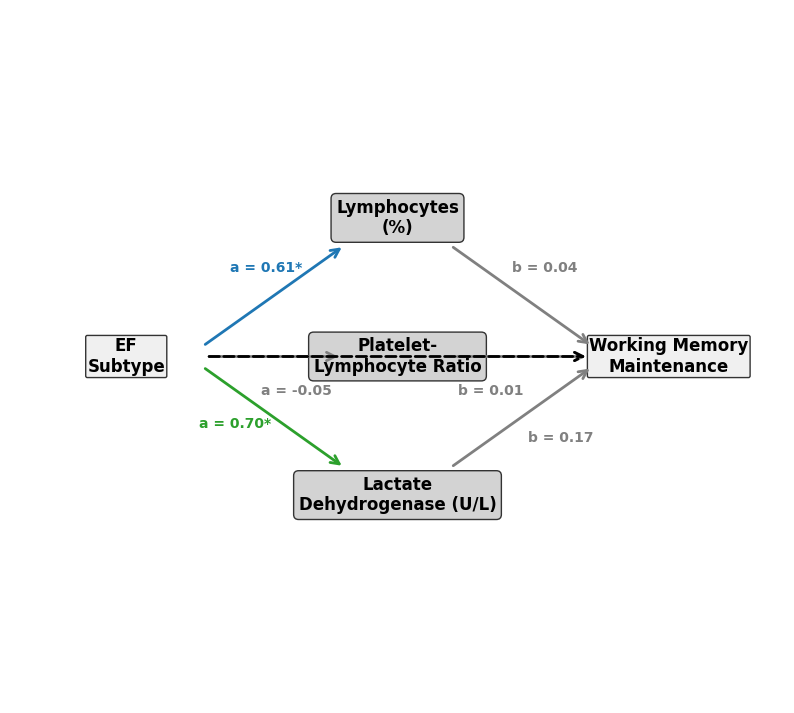

In [6]:
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import contextlib
import json
import os

# 定义一个辅助函数，用于格式化 p 值
def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

# 打开 Excel 文件并读取数据
df = pd.read_excel('rawdata.xlsx')

# 计算所需的差值变量
df['LYMPH_diff'] = df['LYMPH_followup'] - df['LYMPH_baseline']
df['PLR_diff'] = df['PLR_followup'] - df['PLR_baseline']
df['LDH_diff'] = df['LDH_followup'] - df['LDH_baseline']
df['WM_diff'] = df['span in digit span backward task at follow-up'] 


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['LYMPH_diff', 'PLR_diff', 'LDH_diff', 'WM_diff']] = scaler.fit_transform(df[['LYMPH_diff', 'PLR_diff', 'LDH_diff', 'WM_diff']])


# 定义 bootstrap 函数，参数 mediator 表示中介变量名称（LYMPH_diff, PLR_diff, LDH_diff）
def bootstrap_indirect_effect(data, mediator, n_boot=3000, seed=42):
    np.random.seed(seed)
    boot_effects = []
    n = len(data)
    for i in range(n_boot):
        sample = data.sample(n, replace=True)
        # 重新拟合模型，均控制 Age、Gender 和 Education_years
        mod_m = smf.ols(f'{mediator} ~ C(Subtype)', data=sample).fit()
        mod_y = smf.ols(f'WM_diff ~ C(Subtype) + {mediator}', data=sample).fit()
        a = mod_m.params['C(Subtype)[T.2]']
        b = mod_y.params[f'{mediator}']
        boot_effects.append(a * b)
    lower = np.percentile(boot_effects, 2.5)
    upper = np.percentile(boot_effects, 97.5)
    boot_effects = np.array(boot_effects)
    # 双尾检验 p 值计算
    p_value_indirect = 2 * min(np.mean(boot_effects < 0), np.mean(boot_effects > 0))
    p_value_indirect = min(p_value_indirect, 1.0)
    return lower, upper, p_value_indirect

# 修改：增加同时考虑多个中介变量的函数
def bootstrap_parallel_indirect_effects(data, mediators, n_boot=5000, seed=42):
    np.random.seed(seed)
    n = len(data)
    boot_effects_dict = {m: [] for m in mediators}
    boot_total_indirect = []
    
    for i in range(n_boot):
        sample = data.sample(n, replace=True)
        total_indirect = 0
        
        for mediator in mediators:
            mod_m = smf.ols(f'{mediator} ~ C(Subtype)', data=sample).fit()
            mod_y = smf.ols(f'WM_diff ~ C(Subtype) + {mediator}', data=sample).fit()
            a = mod_m.params['C(Subtype)[T.2]']
            b = mod_y.params[f'{mediator}']
            indirect = a * b
            boot_effects_dict[mediator].append(indirect)
            total_indirect += indirect
        
        boot_total_indirect.append(total_indirect)
    
    results = {}
    for mediator in mediators:
        effects = np.array(boot_effects_dict[mediator])
        lower = np.percentile(effects, 2.5)
        upper = np.percentile(effects, 97.5)
        p_value = 2 * min(np.mean(effects < 0), np.mean(effects > 0))
        p_value = min(p_value, 1.0)
        results[mediator] = {'lower': lower, 'upper': upper, 'p_value': p_value}
    
    # 总间接效应
    total_effects = np.array(boot_total_indirect)
    total_lower = np.percentile(total_effects, 2.5)
    total_upper = np.percentile(total_effects, 97.5)
    total_p_value = 2 * min(np.mean(total_effects < 0), np.mean(total_effects > 0))
    total_p_value = min(total_p_value, 1.0)
    results['total'] = {'lower': total_lower, 'upper': total_upper, 'p_value': total_p_value}
    
    # 计算中介变量之间的效应大小差异
    for i, m1 in enumerate(mediators):
        for j, m2 in enumerate(mediators):
            if i < j:  # 避免重复比较
                diff = np.array(boot_effects_dict[m1]) - np.array(boot_effects_dict[m2])
                diff_p_value = 2 * min(np.mean(diff < 0), np.mean(diff > 0))
                diff_p_value = min(diff_p_value, 1.0)
                results[f'{m1}_vs_{m2}'] = {
                    'diff_p_value': diff_p_value,
                    'mean_diff': np.mean(diff)
                }
    
    return results

# 创建结果目录
if not os.path.exists("results"):
    os.makedirs("results")

# 将所有 print 输出整合保存到 txt 文件中
with open('results/print_outputWM_diff.txt', 'w', encoding='utf-8') as f:
    with contextlib.redirect_stdout(f):
        # 查看数据的列名，确保与代码中变量名一致
        print("数据列名：", df.columns.tolist())

        # 计算总效应模型（不含中介变量）
        total_effect_model = smf.ols('WM_diff ~ C(Subtype)', data=df).fit()
        print("\n总效应模型 (WM_diff ~ X):")
        print(total_effect_model.summary())
        
        total_effect_coef = total_effect_model.params['C(Subtype)[T.2]']
        total_effect_p = total_effect_model.pvalues['C(Subtype)[T.2]']
        print(f"\n总效应 (Total Effect) = {total_effect_coef:.4f}, p = {fmt_p(total_effect_p)}")
        
        # 循环分析中介变量，分别为 LYMPH_diff, PLR_diff, LDH_diff
        mediators = ["LYMPH_diff", "PLR_diff", "LDH_diff"]
        indirect_effects = {}
        direct_effects = {}
        proportion_mediated = {}
        all_model_results = {}
        
        for mediator in mediators:
            print("\n---------------------")
            print(f"中介变量： {mediator}")
            print("---------------------\n")
            
            # 中介模型：检验 Subtype 对 mediator 的影响（控制 Age、Gender 和 Education_years）
            model_m = smf.ols(f'{mediator} ~ C(Subtype)', data=df).fit()
            print(f"中介模型 (M ~ X) 结果 for {mediator}:")
            print(model_m.summary())
            
            # 因变量模型：检验 Subtype 和 mediator 对 WM_diff 的影响（控制 Age、Gender 和 Education_years）
            model_y = smf.ols(f'WM_diff ~ C(Subtype) + {mediator}', data=df).fit()
            print(f"\n因变量模型 (WM_diff ~ X + M) 结果 for {mediator}:")
            print(model_y.summary())
            
            # 提取回归系数
            a_coef = model_m.params['C(Subtype)[T.2]']   # Subtype 对 mediator 的效应（路径 a）
            p_value_a = model_m.pvalues['C(Subtype)[T.2]']
            
            b_coef = model_y.params[f'{mediator}']  # mediator 对 WM_diff 的效应（路径 b）
            p_value_b = model_y.pvalues[f'{mediator}']
            
            direct_effect = model_y.params['C(Subtype)[T.2]']  # 直接效应（路径 c'）
            p_value_c = model_y.pvalues['C(Subtype)[T.2]']
            
            # 计算间接效应 a * b
            indirect_effect = a_coef * b_coef
            
            # 存储结果用于后续比较
            indirect_effects[mediator] = indirect_effect
            direct_effects[mediator] = direct_effect
            proportion_mediated[mediator] = (indirect_effect / total_effect_coef) * 100
            
            # 存储模型结果用于作图
            all_model_results[mediator] = {
                'a_coef': a_coef,
                'p_value_a': p_value_a,
                'b_coef': b_coef, 
                'p_value_b': p_value_b,
                'direct_effect': direct_effect,
                'p_value_c': p_value_c,
                'indirect_effect': indirect_effect,
                'proportion': proportion_mediated[mediator]
            }
            
            print(f"\n【结果：{mediator}】")
            print("间接效应 (Indirect Effect) = {:.4f}".format(indirect_effect))
            print("直接效应 (Direct Effect) = {:.4f}".format(direct_effect))
            print("总效应 (Total Effect) = {:.4f}".format(total_effect_coef))
            print("中介效应占总效应的百分比: {:.2f}%".format(proportion_mediated[mediator]))
            
            # Bootstrap 计算间接效应置信区间和 p 值
            ci_lower, ci_upper, p_value_indirect = bootstrap_indirect_effect(df, mediator=mediator, n_boot=5000, seed=42)
            print("\nBootstrap 置信区间 (95%) 的间接效应: {:.4f} [{:.4f}, {:.4f}]".format(indirect_effect, ci_lower, ci_upper))
            print("间接效应的 p 值: {}".format(fmt_p(p_value_indirect)))
            
            # 保存bootstrap结果
            all_model_results[mediator]['ci_lower'] = ci_lower
            all_model_results[mediator]['ci_upper'] = ci_upper
            all_model_results[mediator]['p_value_indirect'] = p_value_indirect
        
        # 中介效应比较
        print("\n\n---------------------")
        print("中介效应比较")
        print("---------------------")
        for mediator in mediators:
            print(f"{mediator}: 间接效应 = {indirect_effects[mediator]:.4f}, 占总效应的 {proportion_mediated[mediator]:.2f}%")
        
        # 找出最强的中介效应
        strongest_mediator = max(proportion_mediated, key=proportion_mediated.get)
        print(f"\n最强的中介效应是 {strongest_mediator}，占总效应的 {proportion_mediated[strongest_mediator]:.2f}%")
        
        # 多重中介效应分析（并行中介分析）
        print("\n\n---------------------")
        print("多重中介效应分析（并行）")
        print("---------------------")
        
        # 构建包含所有中介变量的模型
        formula_all_mediators = 'WM_diff ~ C(Subtype) + ' + ' + '.join(mediators) + ''
        model_all = smf.ols(formula_all_mediators, data=df).fit()
        print("\n包含所有中介变量的模型:")
        print(model_all.summary())
        
        # 使用Bootstrap计算并行中介效应
        parallel_results = bootstrap_parallel_indirect_effects(df, mediators)
        
        print("\n并行中介效应结果:")
        for mediator in mediators:
            result = parallel_results[mediator]
            print(f"\n{mediator}:")
            print(f"Bootstrap 置信区间 (95%): [{result['lower']:.4f}, {result['upper']:.4f}]")
            print(f"p 值: {fmt_p(result['p_value'])}")
        
        print("\n总间接效应:")
        total_result = parallel_results['total']
        print(f"Bootstrap 置信区间 (95%): [{total_result['lower']:.4f}, {total_result['upper']:.4f}]")
        print(f"p 值: {fmt_p(total_result['p_value'])}")
        
        # 中介效应的差异检验
        print("\n中介效应差异检验:")
        for key, result in parallel_results.items():
            if '_vs_' in key:
                m1, m2 = key.split('_vs_')
                print(f"{m1} vs {m2}:")
                print(f"平均差异: {result['mean_diff']:.4f}")
                print(f"差异的 p 值: {fmt_p(result['diff_p_value'])}")

        # 保存用于作图的结果数据
        results_for_plotting = {
            'total_effect': total_effect_coef,
            'total_effect_p': total_effect_p,
            'strongest_mediator': strongest_mediator,
            'model_results': all_model_results,
            'indirect_effects': indirect_effects,
            'direct_effects': direct_effects, 
            'proportion_mediated': proportion_mediated,
            'parallel_results': parallel_results
        }

        # 保存结果为JSON文件
        with open('results/model_results-wm.json', 'w', encoding='utf-8') as json_file:
            # 将不能直接序列化的numpy类型转换为Python类型
            def convert_numpy(obj):
                if isinstance(obj, np.integer):
                    return int(obj)
                elif isinstance(obj, np.floating):
                    return float(obj)
                elif isinstance(obj, np.ndarray):
                    return obj.tolist()
                return obj
            
            # 使用自定义转换函数序列化JSON
            json.dump(results_for_plotting, json_file, default=convert_numpy, indent=4)

print("计算完成！结果已保存到 results 目录下。")
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import numpy as np

# Function for formatting p-values
def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

# Create directory for saving plots
if not os.path.exists("plots"):
    os.makedirs("plots")

# Read analysis results
with open('results/model_results-wm.json', 'r', encoding='utf-8') as f:
    results = json.load(f)

# Extract required data
total_effect_coef = results['total_effect']
total_effect_p = results['total_effect_p']
strongest_mediator = results['strongest_mediator']
model_results = results['model_results']
indirect_effects = results['indirect_effects']
direct_effects = results['direct_effects']
proportion_mediated = results['proportion_mediated']
parallel_results = results['parallel_results']

# List of mediators
mediators = list(model_results.keys())

# Define color scheme
mediator_colors = {
    'LYMPH_diff': '#1f77b4',
    'PLR_diff': '#ff7f0e',
    'LDH_diff': '#2ca02c'
}

mediator_labels = {
    'LYMPH_diff': 'Lymphocytes\n(%)',
    'PLR_diff':   'Platelet-\nLymphocyte Ratio',
    'LDH_diff':   'Lactate\nDehydrogenase (U/L)'
}
node_facecolor = "#f0f0f0"
node_edgecolor = "#333333"
arrow_color = "#1f77b4"
direct_arrow_color = "#ff7f0e"

# 3. Draw combined mediation model visualization
plt.figure(figsize=(10, 9))

# 定义节点位置
positions = {
    'X': (0.15, 0.5),   # X node position
    'Y': (0.85, 0.5),   # Y node position
    'LYMPH_diff': (0.5, 0.7),    # LYMPH_diff mediator position
    'PLR_diff': (0.5, 0.5),    # PLR_diff mediator position
    'LDH_diff': (0.5, 0.3)     # LDH_diff mediator position
}

# Node dimensions parameters
node_width = 0.12       # Width of node boxes
node_height = 0.07      # Height of node boxes
main_node_pad = 0.1     # Padding for main nodes (X, Y)
mediator_node_pad = 0.3 # Padding for mediator nodes

# Arrow parameters
arrow_shrink_a = 15     # How much to shrink arrows at start point
arrow_shrink_b = 15     # How much to shrink arrows at end point
arrow_width = 2         # Line width for arrows
arrow_head_size = 15    # Size of arrowheads

# Mediator node offset parameters (distance from node edge to arrow)
mediator_offset = 0.05 # Distance from mediator node to arrow start/end

# Text position adjustment parameters
a_text_offset_x = {     # X offset for 'a' coefficient text
    'LYMPH_diff': -0.01,
    'PLR_diff': 0.03,
    'LDH_diff': -0.05
}
a_text_offset_y = {     # Y offset for 'a' coefficient text
    'LYMPH_diff': 0.04,
    'PLR_diff': -0.05,
    'LDH_diff': -0.01
}
b_text_offset_x = {     # X offset for 'b' coefficient text
    'LYMPH_diff': 0.03,
    'PLR_diff': -0.04,
    'LDH_diff': 0.05
}
b_text_offset_y = {     # Y offset for 'b' coefficient text
    'LYMPH_diff': 0.04,
    'PLR_diff': -0.05,
    'LDH_diff': -0.03
}

c_text_offset_y = -0.08 # Y offset for 'c' coefficient text

# Function to get the coordinates of node edges
def get_edge_point(from_node, to_node):
    # Calculate direction vector
    dx = positions[to_node][0] - positions[from_node][0]
    dy = positions[to_node][1] - positions[from_node][1]
    
    # Normalize
    length = np.sqrt(dx**2 + dy**2)
    dx = dx / length
    dy = dy / length
    
    # Adjust starting position based on node dimensions
    if from_node in ['X', 'Y']:
        # For main nodes (X, Y), consider their rectangular shape
        if abs(dx) > abs(dy):  # Horizontal predominant direction
            # If moving right
            if dx > 0:
                start_x = positions[from_node][0] + node_width - 0.04
            # If moving left
            else:
                start_x = positions[from_node][0] 
            start_y = positions[from_node][1]
        else:  # Vertical predominant direction
            start_x = positions[from_node][0]
            # If moving up
            if dy > 0:
                start_y = positions[from_node][1] + node_height
            # If moving down
            else:
                start_y = positions[from_node][1] - node_height
    else:
        # For mediator nodes, add offset to ensure gap between node and arrow
        if dx > 0:  # Moving right (towards Y)
            start_x = positions[from_node][0] + mediator_offset
        else:  # Moving left (towards X)
            start_x = positions[from_node][0] - mediator_offset
        
        if dy > 0:  # Moving up
            start_y = positions[from_node][1] + mediator_offset / 2
        elif dy < 0:  # Moving down
            start_y = positions[from_node][1] - mediator_offset / 2
        else:  # Horizontal only
            start_y = positions[from_node][1]
    
    # Adjust ending position based on node dimensions
    if to_node in ['X', 'Y']:
        # For main nodes (X, Y), consider their rectangular shape
        if abs(dx) > abs(dy):  # Horizontal predominant direction
            # If moving right
            if dx > 0:
                end_x = positions[to_node][0] - node_width + 0.04
            # If moving left
            else:
                end_x = positions[to_node][0] + node_width
            end_y = positions[to_node][1]
        else:  # Vertical predominant direction
            end_x = positions[to_node][0]
            # If moving up
            if dy > 0:
                end_y = positions[to_node][1] - node_height
            # If moving down
            else:
                end_y = positions[to_node][1] + node_height
    else:
        # For mediator nodes, add offset to ensure gap between node and arrow
        if dx > 0:  # Moving right
            end_x = positions[to_node][0] - mediator_offset
        else:  # Moving left
            end_x = positions[to_node][0] + mediator_offset
            
        if dy > 0:  # Moving up
            end_y = positions[to_node][1] - mediator_offset / 2
        elif dy < 0:  # Moving down
            end_y = positions[to_node][1] + mediator_offset / 2
        else:  # Horizontal only
            end_y = positions[to_node][1]
        
    return (start_x, start_y), (end_x, end_y)

# Draw nodes
for node, pos in positions.items():
    if node == 'X':
        label = 'EF\nSubtype'
        color = node_facecolor
        bbox_pad = main_node_pad  # Larger padding for main nodes
    elif node == 'Y':
        label = 'Working Memory\nMaintenance'
        color = node_facecolor
        bbox_pad = main_node_pad  # Larger padding for main nodes
    else:  # Mediator variables
        label = mediator_labels[node]
        # Mark significant mediators with special colors
        if float(parallel_results[node]['p_value']) < 0.05:
            color = mediator_colors[node]
        else:
            color = '#d3d3d3'  # Non-significant mediators use gray
        bbox_pad = mediator_node_pad  # Regular padding for mediator nodes
    
    plt.text(pos[0], pos[1], label, 
             ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle=f'round,pad={bbox_pad}', fc=color, ec=node_edgecolor))

# Draw paths
# X to mediator paths
for m in mediators:
    # Determine if the path is significant
    is_sig_a = float(model_results[m]['p_value_a']) < 0.05
    path_color = mediator_colors[m] if is_sig_a else 'gray'
    
    # Get edge coordinates
    start_point, end_point = get_edge_point('X', m)
    
    # Draw the straight arrow (connectionstyle="arc3,rad=0" makes it straight)
    plt.annotate('', xy=end_point, xytext=start_point, 
                 arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0", 
                               linewidth=arrow_width, mutation_scale=arrow_head_size, 
                               shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b,
                               color=path_color))
    
    # Add coefficient annotation for path a
    # Calculate position for text (slightly offset from the midpoint)
    midx = (start_point[0] + end_point[0]) / 2
    midy = (start_point[1] + end_point[1]) / 2
    
    # Apply text offsets
    text_x = midx + a_text_offset_x[m]
    text_y = midy + a_text_offset_y[m]
    
    # Add path a coefficient
    plt.text(text_x, text_y, 
             f"a = {model_results[m]['a_coef']:.2f}" + 
             (f"*" if is_sig_a else ""),
             ha='center', va='center', fontsize=10, color=path_color, weight='bold')

# Mediator to Y paths
for m in mediators:
    # Determine if the path is significant
    is_sig_b = float(model_results[m]['p_value_b']) < 0.05
    path_color = mediator_colors[m] if is_sig_b else 'gray'
    
    # Get edge coordinates
    start_point, end_point = get_edge_point(m, 'Y')
    
    # Draw the straight arrow
    plt.annotate('', xy=end_point, xytext=start_point, 
                 arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0", 
                               linewidth=arrow_width, mutation_scale=arrow_head_size, 
                               shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b,
                               color=path_color))
    
    # Add coefficient annotation for path b
    # Calculate position for text (slightly offset from the midpoint)
    midx = (start_point[0] + end_point[0]) / 2
    midy = (start_point[1] + end_point[1]) / 2
    
    # Apply text offsets
    text_x = midx + b_text_offset_x[m]
    text_y = midy + b_text_offset_y[m]
    
    # Add path b coefficient
    plt.text(text_x, text_y, 
             f"b = {model_results[m]['b_coef']:.2f}" + 
             (f"*" if is_sig_b else ""),
             ha='center', va='center', fontsize=10, color=path_color, weight='bold')

# X to Y direct path (keep this as a dashed line)
start_point, end_point = get_edge_point('X', 'Y')
plt.annotate('', xy=end_point, xytext=start_point, 
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0", 
                           linewidth=arrow_width, linestyle='--', mutation_scale=arrow_head_size, 
                           shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b, color='black'))

# Add direct effect coefficient
direct_midx = (start_point[0] + end_point[0]) / 2
direct_midy = (start_point[1] + end_point[1]) / 2 + c_text_offset_y


# Add legend
legend_elements = []
for m in mediators:
    # Remove newline characters properly
    clean_label = mediator_labels[m].replace('\n', ' ')
    
    if float(parallel_results[m]['p_value']) < 0.05:
        legend_elements.append(
            Patch(facecolor=mediator_colors[m], 
                 label=f'{clean_label}: {proportion_mediated[m]:.1f}% (p={fmt_p(parallel_results[m]["p_value"])})')
        )
    else:
        legend_elements.append(
            Patch(facecolor='#d3d3d3', 
                 label=f'{clean_label}: {proportion_mediated[m]:.1f}% (p={fmt_p(parallel_results[m]["p_value"])})')
        )

legend_elements.append(Patch(facecolor='none', edgecolor='black', linestyle='--', 
                             label=f'Direct Effect: {direct_effects[strongest_mediator]:.2f}'))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

plt.savefig('./image/combined_mediation_model-wm.jpg', dpi=1200, bbox_inches='tight')
plt.show()


## 2.EF改善

## 3.全部分析完成

In [26]:
print("全部分析完成!")

全部分析完成!


In [27]:
print

<function print>